In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipynb.fs

%matplotlib inline
sns.set_theme()

In [2]:
%cd ..

C:\Users\devsn\Desktop\courses\MLOps Zoomcamp


In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
tracking_uri = mlflow.get_tracking_uri()
tracking_uri


'sqlite:///mlflow.db'

In [4]:
mlflow.set_experiment("nyc-taxi")

2023/07/14 22:51:57 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/07/14 22:51:57 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/devsn/Desktop/courses/MLOps Zoomcamp/mlruns/1', creation_time=1689333964153, experiment_id='1', last_update_time=1689333964153, lifecycle_stage='active', name='nyc-taxi', tags={}>

In [5]:
from mlflow import MlflowClient

experiment = MlflowClient().search_experiments()
experiment

[<Experiment: artifact_location='file:///C:/Users/devsn/Desktop/courses/MLOps Zoomcamp/mlruns/1', creation_time=1689333964153, experiment_id='1', last_update_time=1689333964153, lifecycle_stage='active', name='nyc-taxi', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1689326817764, experiment_id='0', last_update_time=1689326817764, lifecycle_stage='active', name='Default', tags={}>]

# Data loading and transformation


In [6]:
df_01 = pd.read_parquet('data/green_tripdata_2022-01.parquet')

df_01.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75


In [7]:
dataset_source = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet"
dataset = mlflow.data.from_pandas(df=df_01, source=dataset_source)


In [8]:
def transform_nyc_green(df):
    
    convert_dtypes = {
        'VendorID': 'category',
        'PULocationID': 'string',
        'DOLocationID': 'string',
        'RatecodeID': 'category',
        'passenger_count': 'Int64',
        'store_and_fwd_flag': 'category',
        'trip_type': 'category',
        'payment_type': 'category'
    }

    return (
        df.astype(convert_dtypes)
        .assign(
            trip_duration=(df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60,
        )
        .query("total_amount >= 3.300000 and trip_distance <= 15.561200") # removing outliers
        .query("trip_duration >= 2.350000 and trip_duration <= 68.453000") # removing outliers
        .query("trip_type == 1 and RatecodeID == 1 and VendorID == 2") # keeping the data simple
        .reset_index()
        .drop(['ehail_fee'], axis=1) # the column has only NULL values
        .drop(['index', 'trip_type', 'RatecodeID', 'VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 
               'store_and_fwd_flag', 'passenger_count', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'DOLocationID', 
               'tolls_amount', 'improvement_surcharge', 'payment_type', 'congestion_surcharge'], axis=1)
    )



In [9]:
df_01 = transform_nyc_green(df_01)
df_01.head()

,trip_distance,total_amount,trip_duration
0,1.69,9.30,8.250000
1,6.26,31.26,21.033333
2,6.47,23.80,20.200000
3,1.15,7.30,6.333333
4,1.30,7.30,6.000000


# Modeling

Let's fit a basic model with just the 2 numerical columns, first.

In [10]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [11]:
features = ['trip_distance', 'total_amount']
target = ['trip_duration']


In [12]:
X = df_01[features]
y = df_01[target]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=42)


In [19]:
with mlflow.start_run(run_name="lin-reg"):
    
    mlflow.set_tag("developer", "dvshnkr") # set tag to the current run

    mlflow.log_input(dataset) # log the input dataset used for the current run
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    mlflow.log_metric("RMSE", rmse) # log metric associated with current run



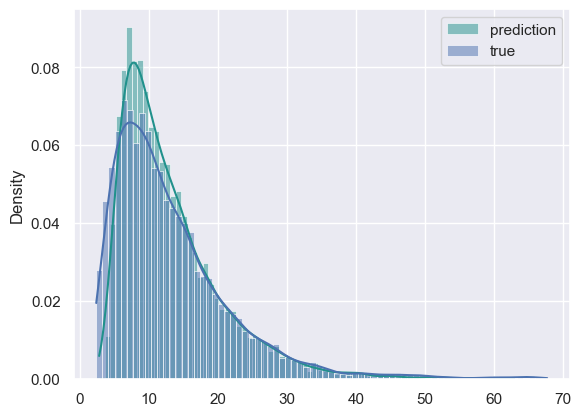

In [20]:
sns.histplot(y_pred, label='prediction', kde=True, stat="density", palette='viridis')
sns.histplot(y_test, label='true', kde=True, stat="density")

plt.legend()

Looks like we're able to capture some information using this simlpe model. 

Trying another linear model (Lasso) to see if there is any improvement...

## Lasso

In [24]:
with mlflow.start_run(run_name="lasso"):
    
    mlflow.set_tag("developer", "dvshnkr") # set tag to the current run

    mlflow.log_input(dataset) # log the input dataset used for the current run
    
    alpha = 1
    mlflow.log_param("alpha", alpha)
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    y_pred = lasso.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    mlflow.log_metric("RMSE", rmse) # log metric associated with current run



In [25]:
lasso.coef_

array([-0.        ,  0.84270536])

In [26]:
X_train.iloc[:3, lasso.coef_ != 0]

,total_amount
15137,35.85
5777,7.30
14156,55.26


The coefficients seem to suggest that the `trip_distance` column is not contributing much here and can be removed; and yet the RMSE is almost as good as it was in the case of the simple LR model. This is probably a trade-off worth considering to make here if one of these models is going to be in production.

## Scaling the variables

Although the variables are not very different in scale, let's try scaling to see if it helps at all.

In [23]:
scaler = StandardScaler()

X_tr_scaled = scaler.fit_transform(X_train)
X_te_scaled = scaler.transform(X_test)

lr_ = LinearRegression()
lr_.fit(X_tr_scaled, y_train)

y_pred = lr_.predict(X_te_scaled)

RMSE = mean_squared_error(y_test, y_pred, squared=False)

RMSE

4.522799576241804

Also, as explained in this [Stack Overflow answer](https://stackoverflow.com/a/70341695), **explained variance will ultimately remain the same** irrespective of scaling. Only the coefficients would be different in both cases. 

Scaling, however, [makes interpretation easier](https://www.quora.com/Do-I-need-to-do-feature-scaling-for-simple-linear-regression).  

## Saving best model

Since the best model was the OLS linear regression model, saving that...

In [24]:
import pickle

In [25]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump(lr, f_out)